# Colab setup

In [1]:
from IPython.display import clear_output

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
    ! {sys.executable} -m pip install pytorch-lifestream
    ! {sys.executable} -m pip install -U 'torch<2'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'pytorch-lightning<2'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'torchvision<0.15.1'  # downgrade for ptls==0.5.x
    ! {sys.executable} -m pip install -U 'torchaudio<2'  # downgrade for ptls==0.5.x

clear_output()

## Data load

In [3]:
import os

if not os.path.exists('data/transactions_train.csv'):
    ! mkdir -p data
    ! curl -OL https://storage.yandexcloud.net/ptls-datasets/age-prediction-nti-sbebank-2019.zip
    ! unzip -j -o age-prediction-nti-sbebank-2019.zip 'data/*.csv' -d data
    ! mv age-prediction-nti-sbebank-2019.zip data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  239M  100  239M    0     0  14.4M      0  0:00:16  0:00:16 --:--:-- 15.1M
Archive:  age-prediction-nti-sbebank-2019.zip
  inflating: data/test.csv           
  inflating: data/small_group_description.csv  
  inflating: data/train_target.csv   
  inflating: data/transactions_train.csv  
  inflating: data/transactions_test.csv  


## Setup

In [4]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl
# import warnings

# warnings.filterwarnings('ignore')
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Data preproccessing

In [5]:
import os
import pandas as pd

data_path = 'data/'

source_data = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))
source_data.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [6]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    col_event_time='trans_date',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
    return_records=True,
)

In [7]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 59.3 s, sys: 15.3 s, total: 1min 14s
Wall time: 1min 23s


In [8]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [9]:
dataset = sorted(dataset, key=lambda x: x['client_id'])

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(24000, 6000)

In [11]:
train[0].keys()

dict_keys(['client_id', 'trans_date', 'event_time', 'small_group', 'amount_rur'])

## Embedding training

Model training in our framework organised via pytorch-lightning (pl) framework.
The key parts of neural networks training in pl are:

    * model (`pytorch_lightning.LightningModule`)
    * data loader (`torch.utils.data.DataLoader`)
    * trainer (`pytorch_lightning.Trainer`)
    
For futher details check https://pytorchlightning.ai/

### Model definition

In [12]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.bert import RtdModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 800, 'out': 16},
        'small_group': {'in': 250, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
)

model = RtdModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Data loader

In [13]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.bert import RtdDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=RtdDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        min_len = 600,
        max_len = 600,
    ),
    train_num_workers=16,
    train_batch_size=256,
)

### Trainer

In [14]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=20,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Training

In [15]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


logger.version = 0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type          | Params
-----------------------------------------------------
0 | _loss              | BCELoss       | 0     
1 | _seq_encoder       | RnnSeqEncoder | 35.9 K
2 | _validation_metric | AUROC         | 0     
3 | _head              | Sequential    | 65    
-----------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number t

{'loss': tensor(0.0289), 'seq_len': tensor(600.)}
CPU times: user 1min 22s, sys: 21 s, total: 1min 43s
Wall time: 3min 59s


### Save sequence encoder for other experiments

In [16]:
torch.save(seq_encoder.state_dict(), "rtd-emb.pt")

## Inference


In [17]:
from ptls.data_load.utils import collate_feature_dict

In [18]:
import numpy as np
import torch
from collections import defaultdict
from functools import reduce

from ptls.data_load.feature_dict import FeatureDict
from ptls.data_load.padded_batch import PaddedBatch

from transformers.tokenization_utils_base import BatchEncoding

In [19]:
inference_data = train[:3000]

In [20]:
inference_dataset = MemoryMapDataset(
    data=inference_data,
    i_filters=[
    SeqLenFilter(min_seq_len=25),
    ],
)

In [21]:
inference_dl = torch.utils.data.DataLoader(
    dataset=inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=32,
    num_workers=12,
)
padded_batch = next(iter(inference_dl)).payload

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
from ptls.frames.inference_module import InferenceModule
from ptls.data_load.padded_batch import PaddedBatch

### Modify inference module for transactions output

In [23]:
class InferenceModuleTransactionEmb(InferenceModule):

    @staticmethod
    def to_pandas(x):
        expand_cols = []
        scalar_features = {}

        for k, v in x.items():

            if type(v) is PaddedBatch:
                v = v.payload
            if type(v) is torch.Tensor:
                v = v.cpu().numpy()
            if type(v) is list or len(v.shape) == 1:
                scalar_features[k] = v
            elif len(v.shape) > 1:
                expand_cols.append(k)
            else:
                scalar_features[k] = None
        dataframes = []

        for col in expand_cols:
            v = x[col].payload.cpu().numpy()
            len_mask = x[col].seq_len_mask.bool().cpu().numpy()

            for i, usr in enumerate(v):
              df_id = pd.DataFrame([scalar_features['client_id'][i] for _ in range(np.sum(len_mask[i]))], columns = ['client_id'])
              df_trx = pd.DataFrame(usr[len_mask[i]], columns=[f'{col}_{i:04d}' for i in range(usr.shape[1])])
              dataframes.append(pd.concat([df_id, df_trx], axis=1))

        return pd.concat(dataframes, axis=0)

In [24]:
inference_module = InferenceModuleTransactionEmb(model=seq_encoder, pandas_output=True, model_out_name='emb')

In [25]:
inference_module.model.seq_encoder.is_reduce_sequence = False

In [26]:
predict = pl.Trainer(gpus=1).predict(inference_module, inference_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [27]:
full_predict = pd.concat(predict, axis=0)

In [28]:
full_predict.shape

(2646251, 65)

In [29]:
mcc_lst = []
amount_lst = []
date_lst = []
for usr in inference_data:
    mcc_lst.extend(usr['small_group'].numpy())
    amount_lst.extend(usr['amount_rur'].numpy())
    date_lst.extend(usr['trans_date'].numpy())

full_predict.insert(loc=1, column='mcc', value=mcc_lst)
full_predict.insert(loc=1, column='amount_rur', value=amount_lst)
full_predict.insert(loc=3, column='trans_date', value=date_lst)

In [42]:
vecs = full_predict.loc[full_predict['client_id'].isin([1187, 36253, 396, 38243, 1002])]

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=250, metric="cosine")

embs = tsne.fit_transform(vecs.loc[:, (vecs.columns != 'mcc') & (vecs.columns != 'amount_rur') & (vecs.columns != 'client_id') & (vecs.columns != 'trans_date')])

In [44]:
vecs['x'] = embs[:, 0]
vecs['y'] = embs[:, 1]

<ipython-input-44-6d69180b3521>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vecs['x'] = embs[:, 0]
<ipython-input-44-6d69180b3521>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vecs['y'] = embs[:, 1]


Text(0.5, 1.0, 'tsne for client_id in [1187, 36253, 396, 38243, 1002]')

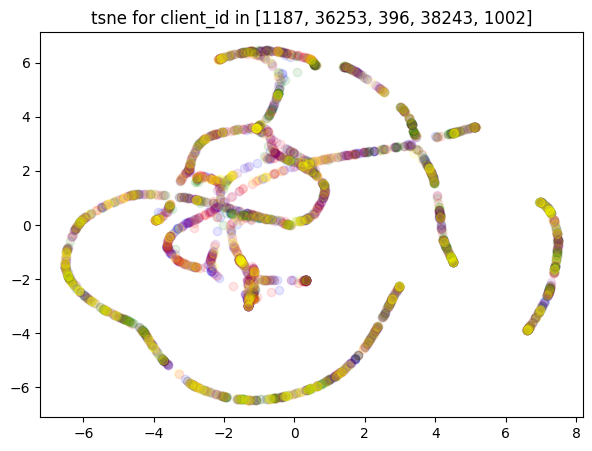

In [52]:
from matplotlib import pyplot as plt
FS = (7, 5)
fig, ax = plt.subplots(figsize=FS)
users = [1187, 36253, 396, 38243, 1002]
colors = ['b', 'r', 'g', 'purple', 'yellow', 'brown']
for usr, clr in zip(users, colors):
    ax.scatter(vecs.loc[vecs['client_id'] == usr].x, vecs.loc[vecs['client_id'] == usr].y, alpha=.1, color = clr)
ax.set_title('tsne for client_id in [1187, 36253, 396, 38243, 1002]')

Text(0.5, 1.0, 'tsne for mcc for client_id=1187')

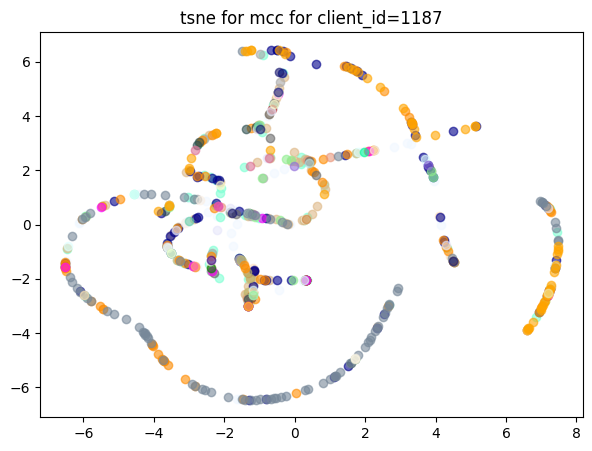

In [53]:
import matplotlib.colors as colors
FS = (7, 5)
mccs = vecs[vecs['client_id'] == 1187].mcc.unique()
colors_list = list(colors.cnames.values())
fig, ax = plt.subplots(figsize=FS)
clr = 0
for mcc in mccs:
    ax.scatter(vecs.loc[(vecs['client_id'] == 1187) & (vecs['mcc'] == mcc)].x, vecs.loc[(vecs['client_id'] == 1187) & (vecs['mcc'] == mcc)].y, alpha=.6, color = colors_list[clr])
    clr += len(colors_list)//len(mccs)
ax.set_title('tsne for mcc for client_id=1187')

Text(0.5, 1.0, 'tsne for trans_date for client_id=1187')

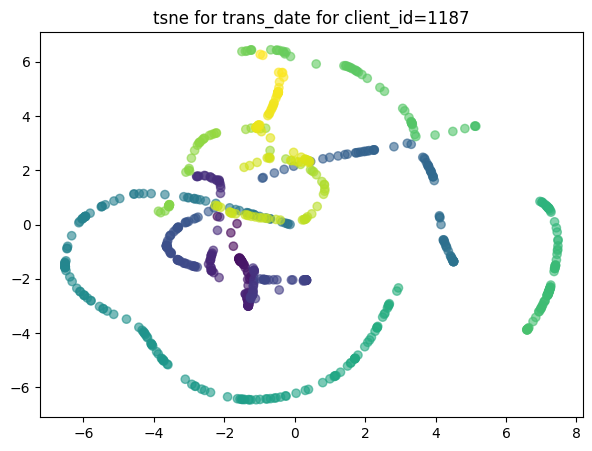

In [54]:
FS = (7, 5)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(vecs.loc[(vecs['client_id'] == 1187)].x, vecs.loc[(vecs['client_id'] == 1187)].y, c=vecs.loc[(vecs['client_id'] == 1187)].trans_date, alpha=.6)
ax.set_title('tsne for trans_date for client_id=1187')

Obtained embeddings can be used as features for model training

For example:

In [48]:
X = full_predict.loc[:, (full_predict.columns != 'mcc') & (full_predict.columns != 'amount_rur') & (full_predict.columns != 'client_id')]
y = full_predict['mcc']

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test = X.values[:100000], X.values[100000:120000]
y_train, y_test = y.values[1:100001], y.values[100001:120001]

In [50]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(learning_rate = 0.01, random_state = 42)
clf.fit(X_train, y_train)
clear_output()

In [51]:
from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.3047